<a href="https://colab.research.google.com/github/Seenuprime/Deep-Learning/blob/main/08_Natural_Language_Processing_%26_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction to NLP Fundamental with TensorFlow

In [1]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


##Getting the dataset

The dataset we're gonna use is kaggle's Introduction to NLP dataset. (text sample of tweets cintaining labels as disaster and non-disaster)

In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
import zipfile
zip_dir = zipfile.ZipFile('nlp_getting_started.zip')
zip_dir.extractall()
zip_dir.close()

--2024-05-07 17:19:18--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.207, 172.217.203.207, 142.250.98.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2024-05-07 17:19:18 (96.3 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [3]:
import pandas as pd
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df['text'][87]

'RT nAAYf: First accident in years. Turning onto Chandanee Magu from near MMA. Taxi rammed into me while I was halfway turned. Everyone conf\x89Û_'

In [6]:
train_df.drop(columns=['keyword', 'location'], inplace=True)
test_df.drop(columns=['keyword', 'location'], inplace=True)

In [7]:
train_df.columns, test_df.columns

(Index(['id', 'text', 'target'], dtype='object'),
 Index(['id', 'text'], dtype='object'))

In [8]:
train_df['target'].unique()

array([1, 0])

In [9]:
## Shuffling the data
train_data = train_df.sample(frac=1, random_state=42) #fract: 1 is telling shuflle 100% of data
test_data = test_df

In [10]:
train_data.head()

,id,text,target
2644,3796,So you have a new weapon that can cause un-ima...,1
2227,3185,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,Aftershock back to school kick off was great. ...,0
6845,9810,in response to trauma Children of Addicts deve...,0


In [11]:
train_data.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [12]:
## Total Samples
len(train_df), len(test_df)

(7613, 3263)

In [13]:
## Visualizing random samples
import random
random_index = random.randint(0, len(train_data)-5)
for row in train_data[['text', 'target']][random_index: random_index+5].itertuples():
  _, text, target = row
  print("Target:",f'{target} (disaster)' if target>0 else f'{target} (not a disaster)')
  print(f"Text:\n {text}\n")
  print("-----\n")

Target: 0 (not a disaster)
Text:
 Having trouble understanding the rotations within a left-leaning Red Black Tree.: My class is currently learni... http://t.co/wGl4LUbnw1

-----

Target: 1 (disaster)
Text:
 The fact that the atomic bombs were called 'Little Boy' and 'Fat man' says a lot about the mentality that went into the attack.

-----

Target: 0 (not a disaster)
Text:
 I'd like to think I'm photogenic but every time I see a pic with me in it I just think to myself 'gosh what a disaster' xD

-----

Target: 1 (disaster)
Text:
 VIDEO: 'We're picking up bodies from water' - Rescuers are searching for hundreds of migrants in the Mediterranean... http://t.co/yhQU5UV6Ok

-----

Target: 0 (not a disaster)
Text:
 My portable closet has collapsed 3x and it finally broke and my mom said 'maybe u should get rid of some clothes' lol how about no

-----



##Split the data to training data and validation data

In [14]:
## The test data does not contain 'target' values so we cannot split the data to validation data
## So we split the data using train_data
from sklearn.model_selection import train_test_split
train_sentence, val_sentence, train_label, val_label = train_test_split(train_data['text'].to_numpy(),
                                                                        train_data['target'].to_numpy(),
                                                                        test_size=0.1,
                                                                        random_state=42)

In [15]:
len(train_sentence), len(val_sentence)

(6851, 762)

## Converting text into numbers

ways to do this:
* Tokenization
* Embedding

###Tokenization

In [16]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [17]:
## Using default TextVectorization parameters
encoder = TextVectorization(max_tokens=None,
                       standardize='lower_and_strip_punctuation',
                       split='whitespace',
                       ngrams=None, ## Create groups of n-words
                       output_mode='int',
                       output_sequence_length=None,
                       pad_to_max_tokens=False)

In [18]:
train_sentence[1].split()

['Imagine', 'getting', 'flattened', 'by', 'Kurt', 'Zouma']

In [19]:
## Find the average number of tokens in the training data
round(sum([len(i.split()) for i in train_sentence])/len(train_sentence))

15

In [20]:
## Set up TextVectorizer variables
max_voc_length = 10000
max_length = 15
encoder = TextVectorization(max_tokens=max_voc_length,
                       output_mode='int',
                       output_sequence_length=max_length)

In [21]:
encoder.adapt(train_sentence)

In [22]:
sample_sentence = "There is a flood in the street!"
encoder([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 74,   9,   3, 232,   4,   2, 698,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [23]:
## Choosing random sample from the training dataset and tokenize it
import random
random_sentence = random.choice(train_sentence)
print(random_sentence)
encoder([random_sentence]).numpy()

Wut a lonely lunch. I got ditched. And I'm hungrier than a hostage!


array([[6638,    3, 2888, 2881,    8,  100,    1,    7,   32,    1,   76,
           3,  509,    0,    0]])

In [24]:
## Get Unique words in the vocabulary
words_in_vocab = encoder.get_vocabulary() ## [UNK] is unknow
print(words_in_vocab[:5]) ## Starting 5 words
print(words_in_vocab[-5:]) ## Last 5 words
len(words_in_vocab) ## number of vocabulary

['', '[UNK]', 'the', 'a', 'in']
['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


10000

###Creating an Embedding using an Embedding layer

using tf.keras.layers.Embedding()
it takes:
* `input_dim` - the size of our vocabulary.
* `ouput_dim` - the size of the embedding output vactor, for example, a value of 100 would mean each token gets represented by a vector 100 long.
* `input_length` - length of the sequences being passed to the embedding layer.

In [25]:
from tensorflow.keras import layers
embedding = layers.Embedding(input_dim=max_voc_length,
                             output_dim=128,
                             embeddings_initializer='uniform',
                             input_length=max_length)
embedding

In [26]:
## Get a random sentence from trining set
random_sentence = random.choice(train_sentence)
print(f'Original Sentence: {random_sentence}\
      \n\n Embedded Version: ')

## Emded the random sentence (turn it into dense vectors of fixed size)
## We have to pass the inter values to the embedded layer
## So we do TextVectorizer first and pass the out put the embedding layer
sample_embed = embedding(encoder([random_sentence]))
sample_embed

Original Sentence: @Jannet2208 I fell off someone's back and hit my head on concrete /: I was bleeding n shit      

 Embedded Version: 


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 3.9182339e-02,  3.4450043e-02,  3.9440241e-02, ...,
         -4.0271498e-02, -3.3597816e-02, -4.0194500e-02],
        [-9.7494349e-03,  3.2678459e-02, -2.7402759e-02, ...,
          1.0406185e-02,  4.8157517e-02,  3.5490703e-02],
        [-3.8889956e-02, -1.0849178e-02,  2.3225550e-02, ...,
         -2.5904402e-03,  4.6994936e-02,  1.7599467e-02],
        ...,
        [-9.7494349e-03,  3.2678459e-02, -2.7402759e-02, ...,
          1.0406185e-02,  4.8157517e-02,  3.5490703e-02],
        [-4.4116389e-02, -4.3738633e-05, -2.2703815e-02, ...,
          4.3396465e-03,  1.4326159e-02, -3.2234564e-02],
        [ 4.7028806e-02,  4.5107219e-02, -5.2355304e-03, ...,
         -1.1380099e-02, -1.0472454e-02, -4.8850179e-03]]], dtype=float32)>

In [27]:
## Checkout singel token embedding
sample_embed[0][0], random_sentence.split()[0]
## the output is for 1 single word in sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.03918234,  0.03445004,  0.03944024,  0.00164909,  0.0188689 ,
        -0.02683252, -0.00154761,  0.00894234,  0.04957068, -0.00433486,
         0.01094233,  0.00718271, -0.0364925 , -0.00888872, -0.04438888,
        -0.04465318, -0.03276837,  0.04233355, -0.0104903 ,  0.01757118,
        -0.01030244, -0.00214068, -0.02770445,  0.02408737,  0.04443318,
        -0.03464162, -0.03659779, -0.03369661, -0.01640762, -0.0385475 ,
         0.04219988,  0.0138017 , -0.0036122 , -0.03989939,  0.01270309,
         0.00820035, -0.03468104,  0.02062375,  0.00435934,  0.01874663,
         0.02194725, -0.00248628,  0.03387329,  0.04749132,  0.01829677,
         0.03289843,  0.03757637,  0.00928945, -0.04599729,  0.00614066,
        -0.04145191,  0.0426468 ,  0.01820019,  0.03219626, -0.02577615,
         0.00475606,  0.00811553, -0.0391085 , -0.04225605,  0.03111907,
        -0.00725396, -0.02112737, -0.03089355, -0.03810703,  0.00634624,
  

## Modelling a text dataset (Series of Experiment)

It's time to start modelling:
* Model 0: Naive Bayes (baseline)
* Model 1: Feed Forword Neural Network (dense model)
* Model 2: LSTM Model (RNN)
* Model 3: GRU Model (RNN)
* Model 4: Bidirectional LSTM (RNN)
* Model 5: 1D CNN
* Model 6: Tensorflow Hub Pretrained Feature Extractor
* Model 7: Same as Model 6 with 10% of the data

steps to follow
* Build a Model
* Fit the Model
* Evaluate the Model

### Model_0. Naive Bayes Model(baseline)

In [28]:
train_sentence[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()), ## Converts text into numbers
    ('clf', MultinomialNB()) ## model
])

## Fit the Pipeline to train_data
model_0.fit(train_sentence, train_label)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [30]:
## Evaluate the Model
model_0_eval = model_0.score(val_sentence, val_label)
print(f"Got the accuracy score for evaluation data: {model_0_eval*100:.2f}%")

Got the accuracy score for evaluation data: 79.27%


In [31]:
## Predicting
model_0_preds = model_0.predict(test_data['text'])
model_0_preds[:10]

array([1, 0, 1, 1, 1, 1, 0, 0, 0, 0])

In [32]:
## Creatign function for evaluating the results
def calculate_results(y_true, y_pred):
  """
  Takes the actual target values (y_true) and predicted target values (y_pred) and
  makes evaluation using different evaluation methods like accuracy_score, precision,
  recall, f1-score, confusion_matrix.

  Args:

  Input:-
    y_true - True values
    y_pred - Predicted values
  Output:-
    Accuracy_Score, Precision, Recall, F1_Score, Confusion_Matrix
  """
  from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
  Accuracy_Score = accuracy_score(y_true, y_pred)
  Precision, Recall, F1_Score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  Confusion_Matrix = confusion_matrix(y_true, y_pred)

  model_result = {'accuracy': Accuracy_Score, 'precision': Precision, 'recall': Recall, 'f1_score': F1_Score, 'confusion_matrix': Confusion_Matrix}

  return model_result

In [33]:
model_0_eval = calculate_results(val_label, model_0.predict(val_sentence))
model_0_eval

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1_score': 0.7862189758049549,
 'confusion_matrix': array([[386,  28],
        [130, 218]])}

### Model_1. Feed-Forword Neural Network

we can create in using
> Sequential()
* encoder (TextVectorizer())
* Embedding()
* Feed-Forword NN (any model)
* Dense layer with activation
* Dense layer with ouput units

refer: https://www.tensorflow.org/text/tutorials/text_classification_rnn


In [34]:
train_sentence.shape, train_label.shape

((6851,), (6851,))

In [35]:
import tensorflow as tf
from tensorflow.keras import layers

input = layers.Input(shape=(1, ), dtype=tf.string)

x = encoder(input)

x = embedding(x)

x = layers.GlobalAveragePooling1D()(x)

output = layers.Dense(1, activation='sigmoid')(x)

model_1 = tf.keras.Model(input, output)


In [36]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 1280129 (4.

In [37]:
## Compile model
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [38]:
history_1 = model_1.fit(x=train_sentence,
                        y=train_label,
                        epochs=5,
                        validation_data=(val_sentence, val_label))

Epoch 1/5
215/215 [==============================] - 15s 53ms/step - loss: 0.6132 - accuracy: 0.6925 - val_loss: 0.5387 - val_accuracy: 0.7507
Epoch 2/5
215/215 [==============================] - 7s 35ms/step - loss: 0.4430 - accuracy: 0.8173 - val_loss: 0.4777 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 7s 33ms/step - loss: 0.3489 - accuracy: 0.8580 - val_loss: 0.4570 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.2865 - accuracy: 0.8873 - val_loss: 0.4638 - val_accuracy: 0.7927
Epoch 5/5
215/215 [==============================] - 4s 19ms/step - loss: 0.2389 - accuracy: 0.9126 - val_loss: 0.4810 - val_accuracy: 0.7874


<Axes: >

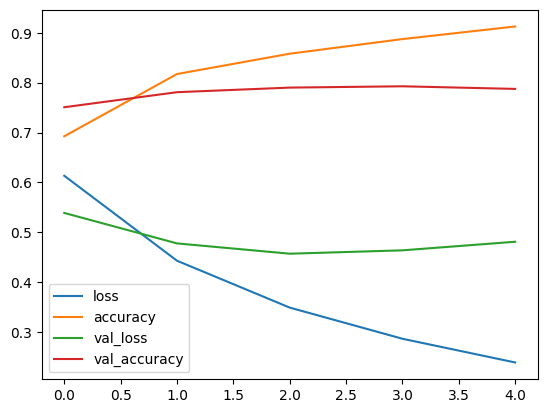

In [39]:
import pandas as pd
pd.DataFrame(history_1.history).plot()

In [40]:
## check the results
model_1_eval = model_1.evaluate(val_sentence, val_label)
model_1_eval

24/24 [==============================] - 0s 2ms/step - loss: 0.4810 - accuracy: 0.7874


[0.4809703528881073, 0.787401556968689]

In [41]:
model_1_preds_probs = model_1.predict(val_sentence)
model_1_preds_probs.shape

24/24 [==============================] - 0s 2ms/step


(762, 1)

In [42]:
model_1_preds_probs[0]

array([0.34595978], dtype=float32)

In [43]:
## Converting the probability to intergers (label format)
model_1_preds_probs = [0 if value < 0.5 else 1 for value in model_1_preds_probs]
model_1_preds_probs[:5]

[0, 1, 1, 0, 0]

In [44]:
calculate_results(val_label, model_1_preds_probs)

{'accuracy': 0.7874015748031497,
 'precision': 0.7937136229340627,
 'recall': 0.7874015748031497,
 'f1_score': 0.7839588199365206,
 'confusion_matrix': array([[367,  47],
        [115, 233]])}

### Visualizing Learned embedding

In [47]:
## Get the vocabulary from encoder (TextVectorizer)
words_in_vocab = encoder.get_vocabulary()
words_in_vocab[:10], len(words_in_vocab)

(['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'], 10000)

In [49]:
## Model_1 summary
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 1280129 (4.

In [59]:
## Get the weight matrix of embedding layer
## these are numerical representation of each token in the training data , which has been learned for 5 epoch
embed_weights = model_1.get_layer('embedding').get_weights()[0]
print(embed_weights.shape)

(10000, 128)


> word enbedding: https://www.tensorflow.org/text/guide/word_embeddings

> tensorflow projector: https://projector.tensorflow.org/

In [60]:
## This code is taken by tensorflow word embedding documentation
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

## This code will output 2 files

In [61]:
## Download files
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>